In [1]:
import copy
import japanize_matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy
from matplotlib.pyplot import imshow
from numpy.random import randn
from scipy import stats
import matplotlib.pyplot as plt
np.random.seed(42)

# 問題21 (b)

In [2]:
def f(x):
    return np.exp(beta_0 + np.dot(beta, x)) / (1 + np.exp(beta_0 + np.dot(beta, x)))

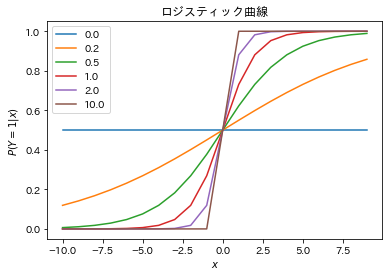

In [3]:
beta_0 = 0
beta_seq = np.array([0, 0.2, 0.5, 1, 2, 10])
m = len(beta_seq)
x = np.arange(-10, 10)
for i in range(m):
    beta = beta_seq[i]  #betaの値を変更
    plt.plot(x, f(x), label=beta_seq[i])   #ロジスティック関数を描画
plt.title("ロジスティック曲線")
plt.xlabel("$x$")
plt.ylabel("$P(Y=1|x)$")
plt.legend()

# 問題22

$N = 100$に対して$p = 2$の場合

In [4]:
N = 100
p = 2
X = np.random.randn(N, p)
X = np.concatenate([np.ones(N).reshape(N, 1), X], axis=1)
beta = np.random.randn(p+1)
y = np.zeros(N)
s = np.dot(X, beta)
prob = 1 / (1 + np.exp(s))
for i in range(N):
    if np.random.rand(1) > prob[i]:
        y[i] = 1
    else:
        y[i] = -1
beta

array([0.35778736, 0.56078453, 1.08305124])

In [5]:
beta = np.inf
gamma = np.random.randn(p + 1)
while np.sum((beta - gamma) ** 2) > 0.001:
    beta = gamma.copy()
    s = np.dot(X, beta)
    v = np.exp(-s * y)
    u = y * v / (1 + v)
    w = v / (1 + v) ** 2
    z = s + u / w
    W = np.diag(w)
    gamma = np.dot(np.linalg.inv(X.T @ W @ X), np.dot(X.T @ W, z))       ##
    print(gamma)
beta    

[-0.08319037  0.64260297  1.08943998]
[0.46802113 0.75346512 0.56215532]
[0.42157733 0.78281238 0.67917968]
[0.42198408 0.78533849 0.68339308]


array([0.42157733, 0.78281238, 0.67917968])

$N = 100$に対して$p = 200$の場合$\beta$の各値が大きくなってoverflowが発生している

In [6]:
N = 10
p = 20
X = np.random.randn(N, p)
X = np.concatenate([np.ones(N).reshape(N, 1), X], axis=1)
beta = np.random.randn(p+1)
y = np.zeros(N)
s = np.dot(X, beta)
prob = 1 / (1 + np.exp(s))
for i in range(N):
    if np.random.rand(1) > prob[i]:
        y[i] = 1
    else:
        y[i] = -1
beta = np.inf
gamma = np.random.randn(p + 1)
while np.sum((beta - gamma) ** 2) > 1e-10:
    beta = gamma.copy()
    s = np.dot(X, beta)
    v = np.exp(-s * y)
    u = y * v / (1 + v)
    w = v / (1 + v) ** 2
    z = s + u / (w + 1e-10) #divide by zero を防ぐ
    W = np.diag(w)
    gamma = np.dot(np.linalg.inv(X.T @ W @ X), np.dot(X.T @ W, z))       ##
#    print(gamma)
beta    

<ipython-input-6-e171288a67a7>:19: RuntimeWarning: overflow encountered in exp
  v = np.exp(-s * y)
<ipython-input-6-e171288a67a7>:20: RuntimeWarning: invalid value encountered in true_divide
  u = y * v / (1 + v)
<ipython-input-6-e171288a67a7>:21: RuntimeWarning: invalid value encountered in true_divide
  w = v / (1 + v) ** 2


array([ -455782., 11779920.,  -405240., -1183160., -2064004.,  3737908.,
        -721972., -3214680., -3661340.,  1798388.,  1121604.,  1165528.,
       -1881996., -1350324.,  4851096.,   381573.,  7384400.,   303920.,
       -2144132., -1236972.,   495416.])

# 問題24

In [7]:
# Linuxでの実行（Windows, Google Colaboratory不可）
import numpy as np
import matplotlib.pyplot as plt
import glmnet_python
import sys
from cvglmnet import cvglmnet
from cvglmnetCoef import cvglmnetCoef
from cvglmnetPlot import cvglmnetPlot

In [8]:
# Linuxマシンのフォルダに"breastcancer.csv"をおく
x = np.loadtxt("../data/breastcancer.csv",
               delimiter=",", skiprows=1, usecols=range(1000))
y = np.loadtxt("../data/breastcancer.csv",
               delimiter=",", skiprows=1, dtype="unicode", usecols=1000)
n = len(y)
yy = np.ones(n)
for i in range(n):
    if y[i] == "control":
        yy[i] = 1
    else:
        yy[i] = -1
fit1 = cvglmnet(x=x.copy(), y=yy.copy(), ptype="deviance", family="binomial")
fit2 = cvglmnet(x=x.copy(), y=yy.copy(), ptype="class", family="binomial")
beta = cvglmnetCoef(fit1)
np.sum(beta != 0)

/opt/conda/lib/python3.9/site-packages/numpy/lib/scimath.py:288: RuntimeWarning: divide by zero encountered in log
  return nx.log(x)


35

非ゼロ要素の個数は$35$

# 問題26

In [9]:
def soft_th(lam, x):
    return np.sign(x) * np.maximum(np.abs(x) - lam, np.zeros(1))

def linear_lasso(X, y, lam=0, beta=None):
    n, p = X.shape
    if beta is None:
        beta = np.zeros(p)
    X, y, X_bar, X_sd, y_bar = centralize(X, y)   # 中心化（下記参照）
    eps = 1
    beta_old = copy.copy(beta)
    while eps > 0.00001:    # このループの収束を待つ
        for j in range(p):
            r = y
            for k in range(p):
                if j != k:
                    r = r - X[:, k] * beta[k]
            z = (np.dot(r, X[:, j]) / n) / (np.dot(X[:, j], X[:, j]) / n)
            beta[j] = soft_th(lam, z)
        eps = np.linalg.norm(beta - beta_old, 2)
        beta_old = copy.copy(beta)
    beta = beta / X_sd   # 各変数の係数を正規化前のものに戻す
    beta_0 = y_bar - np.dot(X_bar, beta)
    return beta, beta_0

def centralize(X0, y0, standardize=True):
    X = copy.copy(X0)
    y = copy.copy(y0)
    n, p = X.shape
    X_bar = np.zeros(p)                   # Xの各列の平均
    X_sd = np.zeros(p)                    # Xの各列の標準偏差
    for j in range(p):
        X_bar[j] = np.mean(X[:, j])
        X[:, j] = X[:, j] - X_bar[j]      # Xの各列の中心化
        X_sd[j] = np.std(X[:, j])
        if standardize is True:
            X[:, j] = X[:, j] / X_sd[j]   # Xの各列の標準化
    if np.ndim(y) == 2:
        K = y.shape[1]
        y_bar = np.zeros(K)               # yの平均
        for k in range(K):
            y_bar[k] = np.mean(y[:, k])
            y[:, k] = y[:, k] - y_bar[k]  # yの中心化
    else:                                 # yがベクトルの場合
        y_bar = np.mean(y)
        y = y - y_bar
    return X, y, X_bar, X_sd, y_bar

def W_linear_lasso(X, y, W, lam=0):
    n, p = X.shape
    X_bar = np.zeros(p)
    for k in range(p):
        X_bar[k] = np.sum(np.dot(W, X[:, k])) / np.sum(W)
        X[:, k] = X[:, k] - X_bar[k]
    y_bar = np.sum(np.dot(W, y)) / np.sum(W)
    y = y - y_bar
    L = np.linalg.cholesky(W)  #
#   L = np.sqrt(W)
    u = np.dot(L, y)
    V = np.dot(L, X)
    beta, beta_0 = linear_lasso(V, u, lam)
    beta_0 = y_bar - np.dot(X_bar, beta)
    return beta_0, beta

def multi_lasso(X, y, lam):
    n, p = X.shape
    K = len(set(y))
    beta = np.ones((K, p))
    gamma = np.zeros((K, p))
    while np.linalg.norm(beta - gamma, 2) > 0.1:
        gamma = beta.copy()
        for k in range(K):
            r = 0
            for h in range(K):
                if k != h:
                    r = r + np.exp(np.dot(X, beta[h, :]))
            v = np.exp(np.dot(X, beta[k, :])) / r
            u = (y == k) - v / (1 + v)
            w = v / (1 + v) ** 2
            z = np.dot(X, beta[k, :]) + u / w
            beta_0, beta_1 = W_linear_lasso(X[:, range(1, p)],
                                            z, np.diag(w), lam=lam)
            beta[k, :] = np.block([beta_0, beta_1]).copy()
    for j in range(p):
        med = np.median(beta[:, j])
        for h in range(K):
            beta[h, j] = beta[h, j] - med
    return beta

In [10]:
# Linuxでの実行（Windows, Google Colaboratory不可）
import numpy as np
import matplotlib.pyplot as plt
import glmnet_python
from glmnet import glmnet
import sys
from cvglmnet import cvglmnet
from cvglmnetCoef import cvglmnetCoef
from cvglmnetPlot import cvglmnetPlot

In [11]:
from sklearn.datasets import load_iris
iris = load_iris()
X = np.array(iris["data"])
y = np.array(iris["target"], dtype="float64")
cvfit3 = cvglmnet(x=X.copy(), y=y.copy(),
                  ptype="deviance", family="multinomial")
lam_min = cvfit3["lambda_min"]
beta = cvglmnetCoef(cvfit3)
print(lam_min)
print(beta)

[0.00077805]
[array([[ 9.2302786 ],
       [ 0.        ],
       [ 2.6568387 ],
       [-2.73371535],
       [-0.46547548]]), array([[5.62976947],
       [0.71170415],
       [0.        ],
       [0.        ],
       [0.        ]]), array([[-12.78950282],
       [  0.        ],
       [ -2.20996807],
       [  3.35592123],
       [  7.69194562]])]


/opt/conda/lib/python3.9/site-packages/numpy/lib/scimath.py:288: RuntimeWarning: divide by zero encountered in log
  return nx.log(x)
/opt/conda/lib/python3.9/site-packages/glmnet_python-0.2.0-py3.9.egg/glmnet_python/cvmultnet.py:72: RuntimeWarning: invalid value encountered in multiply
  ly = bigY*scipy.log(bigY)


/opt/conda/lib/python3.9/site-packages/glmnet_python-0.2.0-py3.9.egg/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)


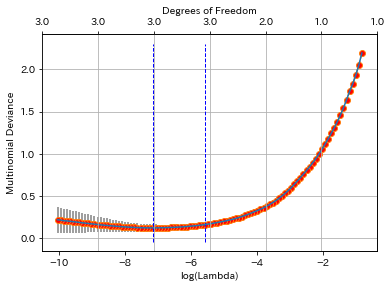

In [12]:
fig3 = plt.figure()
cvglmnetPlot(cvfit3)
fig3.savefig("img3.png")

In [13]:
def table_count(m, u, v):
    n = u.shape[0]
    count = np.zeros([m, m])
    for i in range(n):
        count[int(u[i]), int(v[i])] += 1
    return(count)

K = 3
p = 5
n = 150
gamma = np.zeros((K, p))
for k in range(K):
    for j in range(p):
        gamma[k, j] = np.sum(beta[k][j])
v = np.zeros(n)
for i in range(n):
    max_value = -np.inf
    for k in range(K):
        value = gamma[k, 0] + np.dot(gamma[k, range(1, p)], X[i, :])    #空欄
        if value > max_value:
            v[i] = k
            max_value = value
table_count(3, y, v)

array([[50.,  0.,  0.],
       [ 0., 47.,  3.],
       [ 0.,  1., 49.]])

# 問題28

In [14]:
def poisson_lasso(X, y, lam):
    p = X.shape[1]   # pはすべて1の列を含んでいる
    beta = np.random.randn(p)
    gamma = np.random.randn(p)
    while np.sum((beta - gamma) ** 2) > 0.0001:
        beta = gamma
        s = np.dot(X, beta)                    #デザイン行列と重みの積
        w = np.exp(s)                          #exp
        u = y - w                              #uの計算
        z = s + u / w                          
        gamma_0, gamma_1 = W_linear_lasso(X[:, range(1, p)],
                                          z, np.diag(w), lam)
        gamma = np.block([gamma_0, gamma_1]).copy()
        print(gamma)
    return gamma

In [15]:
N = 100    # lambdaの値が小さいと発散して，推定値が出ないことがある。
p = 3
X = np.random.randn(N, p)
X = np.concatenate([np.ones(N).reshape(N, 1), X], axis=1)
beta = np.random.randn(p + 1)
s = np.dot(X, beta)
y = np.random.poisson(lam=np.exp(s))
print(beta)


[-0.04946371  0.67481949 -1.12272202  0.38240975]


In [16]:
poisson_lasso(X,y,2)

[ 2.21953756 -0.31371836  0.35286932 -0.        ]
[ 1.64649324 -0.          0.          0.        ]
[ 1.17841304  0.         -0.          0.        ]
[ 1.02784931  0.         -0.          0.        ]
[ 1.01530996  0.         -0.          0.        ]
[ 1.01523068  0.         -0.          0.        ]


array([ 1.01523068,  0.        , -0.        ,  0.        ])

# 問題29

In [17]:
import pandas as pd
from lifelines import KaplanMeierFitter

In [18]:
df = pd.read_csv("../data/kidney.csv")
df.drop(df.columns[0], axis=1, inplace=True)
df

,id,time,status,age,sex,disease,frail
0,1,8,1,28,1,Other,2.3
1,1,16,1,28,1,Other,2.3
2,2,23,1,48,2,GN,1.9
3,2,13,0,48,2,GN,1.9
4,3,22,1,32,1,Other,1.2
...,...,...,...,...,...,...,...
71,36,16,0,42,2,Other,0.7
72,37,6,0,52,2,PKD,2.1
73,37,78,1,52,2,PKD,2.1
74,38,63,1,60,1,PKD,1.2


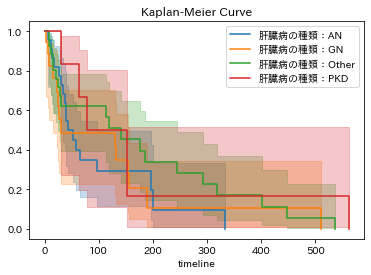

In [19]:
kmf = KaplanMeierFitter()
ax = None
for name, group in df.groupby("disease"):
    kmf.fit(group["time"], event_observed=group["status"],
            label="肝臓病の種類：" + str(name))
    if ax is None:
        ax = kmf.plot()
    else:
        ax = kmf.plot(ax=ax)
plt.title("Kaplan-Meier Curve")
plt.show()

# 問題32

## (a)

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glmnet_python
from glmnet import glmnet
from glmnetCoef import glmnetCoef
import sys
from cvglmnet import cvglmnet
from cvglmnetCoef import cvglmnetCoef
from cvglmnetPlot import cvglmnetPlot
import os
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr
from lifelines import KaplanMeierFitter

In [21]:
base = importr("base")
base.load("../data/LymphomaData.rda")
w = robjects.globalenv["patient.data"]
X = np.array(w[0]).T
y = np.array(w[1])
delta = np.array(w[2])
v = np.concatenate([y.reshape(240, 1), delta.reshape(240, 1)], axis=1)
fit = glmnet(x=X.copy(), y=v.copy(), family="cox")
beta = glmnetCoef(fit, s=np.float64([0.119787]))
print(np.sum(beta != 0))

29


29個の要素が非ゼロとなっている

## (b)

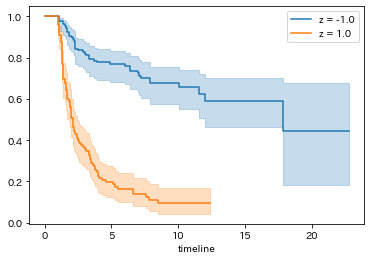

In [22]:
z = np.sign(np.dot(X, beta))
df2 = pd.DataFrame(
    np.concatenate(
        [y.reshape(240, 1), delta.reshape(240, 1), z], axis=1))
df2.columns = ["time", "status", "sign"]
fig = plt.figure()
kmf = KaplanMeierFitter()
ax = None
for name, group in df2.groupby("sign"):
    kmf.fit(group["time"], event_observed=group["status"],
            label="z = " + str(name))
    if ax is None:
        ax = kmf.plot()
    else:
        ax = kmf.plot(ax=ax)

In [23]:
#plt.title("Kaplan-Meier Curve")
#fig.savefig("img7.png")

# 問題32

In [24]:
import scipy, importlib, pprint, matplotlib.pyplot as plt, warnings
from glmnet import glmnet; from glmnetPlot import glmnetPlot 
from glmnetPrint import glmnetPrint; from glmnetCoef import glmnetCoef; from glmnetPredict import glmnetPredict
from cvglmnet import cvglmnet; from cvglmnetCoef import cvglmnetCoef
from cvglmnetPlot import cvglmnetPlot; from cvglmnetPredict import cvglmnetPredict

In [25]:
df = pd.read_csv("../data/leukemia_big.csv", names=range(72)).T

In [26]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,7119,7120,7121,7122,7123,7124,7125,7126,7127,7128
0,ALL,-1.533621735,-1.235672925,-0.333982875,0.488702121,-1.300893264,-1.682668245,-2.010994928,-1.449185684,0.035344171,...,0.385566637,1.268787786,-0.217953576,0.25538086,-1.057940081,1.295991951,0.733853066,-0.301622172,0.133657104,-0.825595612
1,ALL,-0.867609617,-1.275500531,0.375926519,0.444010978,-1.229659818,-1.642071845,0.57291921,-1.588303607,0.21957414,...,-0.158356485,0.822879505,-1.369024157,0.542520961,-0.796526794,-0.2184937,0.378380453,-0.663166359,-0.663166359,-0.611044879
2,ALL,-0.433171907,-1.184492247,-0.459196002,0.436263539,-1.325882367,-1.407263942,-0.264655224,-1.147712888,-0.573540803,...,0.662728335,0.642714155,-0.466828186,0.856140037,-0.416815974,1.132893256,0.475668505,-0.530137975,1.566946374,-0.805978415
3,ALL,-1.671903187,-1.596423985,-1.422571436,0.193352945,-1.818328843,-1.744469301,-1.793196519,-1.446177699,-0.325814834,...,0.161917961,0.462715198,-0.585184983,-0.181007943,-0.611256782,1.113076885,0.148928156,-0.6259453,0.871972365,-1.037245914
4,ALL,-1.187689367,-1.335255683,-0.797492909,0.235631518,-1.311205961,-1.654380542,-1.441690105,-1.058555601,-0.582683167,...,0.176720583,0.750757803,-0.380080665,0.526297612,-0.888026343,0.719203228,0.419502118,-0.487513844,0.358998761,-0.742857958


In [27]:
y = df.iloc[:,0].apply(lambda x: 0 if x == "ALL" else 1)
X = df.iloc[:,1:]

In [28]:
from sklearn.model_selection import train_test_split

In [29]:
X_train, X_test, y_train, y_test =  train_test_split(X,y,train_size=0.8, random_state=42, stratify=y)

In [30]:
X_train = X_train.values.astype('float')
X_test = X_test.values.astype('float')
y_train = y_train.values.astype('float')
y_test = y_test.values.astype('float')

In [31]:
# Linuxマシンのフォルダに"breastcancer.csv"をおく
fit1 = cvglmnet(x=X_train.copy(), y=y_train.copy(), ptype="deviance", family="binomial")
fit2 = cvglmnet(x=X_train.copy(), y=y_train.copy(), ptype="class", family="binomial")

/opt/conda/lib/python3.9/site-packages/glmnet_python-0.2.0-py3.9.egg/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/opt/conda/lib/python3.9/site-packages/glmnet_python-0.2.0-py3.9.egg/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)


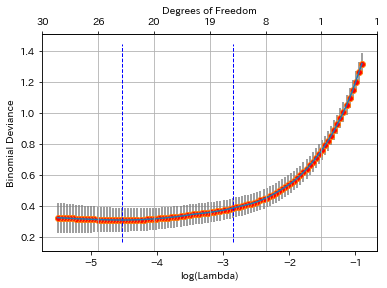

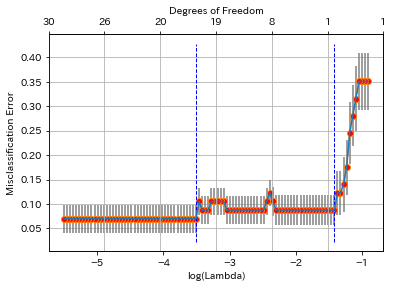

In [32]:
fig = plt.figure()
cvglmnetPlot(fit1)
fig2 = plt.figure()
cvglmnetPlot(fit2)

In [33]:
lam_min = fit1['lambda_min']
print(lam_min)

[0.01077568]


上がlogloss, 下がaccuracy基準での$\lambda$ごとの値  
今回はlogloss基準でモデル選択を行う  
CVの結果$lambda = 0.01077568$が最適である

In [34]:
pred = cvglmnetPredict(fit1, X_test, s = lam_min, ptype='class')

In [35]:
from sklearn.metrics import accuracy_score
accuracy_score(pred,y_test)    

1.0

従って正答率100%で完璧に予測することができた...